# Clasificación de reseñas de IMDB con modelos MLP en PyTorch: comparación de capacidad del modelo y regularización (L2 y Dropout) para estudiar el sobreajuste
### *Universidad Nacional Autónoma de México*
## Autor: **Sebastián González Juárez**

## Idea general: IMDB (binario) con MLP y estudio de sobreajuste/regularización

**Objetivo.** Clasificar reseñas de IMDB (positivo/negativo) representándolas como vectores *bag-of-words* de 10 000 términos y comparar cómo la **capacidad del modelo** y la **regularización** afectan el **sobreajuste**.

### Flujo del experimento
1. **Carga y vectorización**
   - Se usan índices de palabras limitados a `num_words=10000`.
   - Cada reseña → vector binario de tamaño 10 000 (1 si la palabra aparece).

2. **Modelos MLP**
   - Arquitecturas:
     - **Original**: 16 → 16 → 1 (sigmoid).
     - **Más pequeño**: 4 → 4 → 1.
     - **Más grande**: 512 → 512 → 1.
   - Activación **ReLU** en capas ocultas; salida **sigmoide** para probabilidad.

3. **Entrenamiento y validación**
   - Pérdida: **Binary Cross-Entropy**.
   - Optimizador: **RMSProp**.
   - División: `validation_split = 0.4` (40% para validación).
   - Métrica principal para comparar: **pérdida en validación** (*val_loss*).

4. **Regularización**
   - **L2 (weight decay)**: penaliza pesos grandes → reduce sobreajuste.
   - **Dropout**: apaga aleatoriamente neuronas en entrenamiento → mejora generalización.

## Qué se analiza en las gráficas


## 1) Instalación y “setup”

In [1]:
import math, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import RMSprop
import matplotlib.pyplot as plt

In [2]:
# Reproducibilidad
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##2) Carga del IMDB (desde Keras) y vectorización “bag-of-words”

Se usa keras.datasets.imdb solo para descargar índices de palabras (porque Torch no trae este preprocesado igual). Luego convierte cada reseña en un vector binario de tamaño 10 000 (1 si la palabra aparece, 0 si no).

In [4]:
from keras.datasets import imdb

In [5]:
NUM_WORDS = 10_000

Descargar datos (solo train):

In [6]:
(train_data, train_labels), _ = imdb.load_data(num_words=NUM_WORDS)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Vectorización: bolsa de palabras binaria:

In [7]:
def vectorize_sequences(sequences, dimension=NUM_WORDS):
    # Matriz (num_muestras, vocabulario) binaria
    results = np.zeros((len(sequences), dimension), dtype="float32")
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results

In [8]:
X = vectorize_sequences(train_data)            # shape: (25000, 10000)
y = np.array(train_labels, dtype="float32")    # shape: (25000,)
X.shape, y.shape

((25000, 10000), (25000,))

## 3) Pasar a tensores de PyTorch y crear DataLoaders

Se divide en 60% entrenamiento y 40% validación (igual que validation_split=0.4), crea DataLoader con batch_size=512.

In [9]:
BATCH_SIZE = 512
EPOCHS = 20
train_ratio = 0.6

Tensores:

In [10]:
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).unsqueeze(1)  # (N,1) para BCE

Dataset completo y split train/val:

In [11]:
full_ds = TensorDataset(X_tensor, y_tensor)
n_total = len(full_ds)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

In [12]:
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

In [13]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
n_train, n_val

(15000, 10000)

##4) Definir modelos (original / pequeño / grande) y utilidades de entrenamiento

Se definen arquitecturas equivalentes a Keras:

- Original: 16-16-sigmoid

- Pequeño: 4-4-sigmoid

- Grande: 512-512-sigmoid

Modelo original: una red base con cierta cantidad de parámetros.

Modelo más pequeño: una red con menos capas o menos neuronas por capa → menor capacidad de representación.

Modelo más grande: tiene más capas y/o más neuronas por capa → mayor capacidad de aprendizaje.

In [14]:
# 4.1 Bloques de red
class MLP(nn.Module):
    def __init__(self, hidden1, hidden2, input_dim=NUM_WORDS, p_dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.drop = nn.Dropout(p_dropout)

    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)  # logits (sin sigmoid)
        return x

In [15]:
# 4.2 Bucle de entrenamiento/validación
def train_one_model(model, train_loader, val_loader, epochs=EPOCHS, lr=1e-3, weight_decay=0.0):
    """
    weight_decay implementa L2 (equivale a kernel_regularizer en Keras).
    """
    model = model.to(device)
    opt = RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for ep in range(1, epochs+1):
        # ---- Entrenamiento ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # ---- Validación ----
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)

                # Métrica de accuracy (umbral 0.5 tras sigmoid)
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.numel()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Época {ep:02d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    return history, model

## 5) Experimento 1: Modelo original (16-16)

In [16]:
model_original = MLP(16, 16)
hist_original, model_original = train_one_model(model_original, train_loader, val_loader, epochs=EPOCHS, lr=1e-3)
val_loss_original = hist_original["val_loss"]

Época 01/20 | train_loss=0.5078 | val_loss=0.3522 | val_acc=0.8838
Época 02/20 | train_loss=0.2737 | val_loss=0.2875 | val_acc=0.8919
Época 03/20 | train_loss=0.1944 | val_loss=0.2750 | val_acc=0.8934
Época 04/20 | train_loss=0.1553 | val_loss=0.2994 | val_acc=0.8840
Época 05/20 | train_loss=0.1247 | val_loss=0.2833 | val_acc=0.8916
Época 06/20 | train_loss=0.1009 | val_loss=0.2996 | val_acc=0.8885
Época 07/20 | train_loss=0.0830 | val_loss=0.3672 | val_acc=0.8756
Época 08/20 | train_loss=0.0686 | val_loss=0.3438 | val_acc=0.8839
Época 09/20 | train_loss=0.0545 | val_loss=0.3664 | val_acc=0.8819
Época 10/20 | train_loss=0.0436 | val_loss=0.4214 | val_acc=0.8741
Época 11/20 | train_loss=0.0359 | val_loss=0.4180 | val_acc=0.8798
Época 12/20 | train_loss=0.0270 | val_loss=0.4462 | val_acc=0.8780
Época 13/20 | train_loss=0.0209 | val_loss=0.4754 | val_acc=0.8769
Época 14/20 | train_loss=0.0154 | val_loss=0.5026 | val_acc=0.8761
Época 15/20 | train_loss=0.0114 | val_loss=0.5342 | val_acc=0.

##6) Experimento 2: Modelo más pequeño (4-4)

In [17]:
model_small = MLP(4, 4)
hist_small, model_small = train_one_model(model_small, train_loader, val_loader, epochs=EPOCHS, lr=1e-3)
val_loss_small = hist_small["val_loss"]

Época 01/20 | train_loss=0.6877 | val_loss=0.6720 | val_acc=0.5050
Época 02/20 | train_loss=0.6645 | val_loss=0.6584 | val_acc=0.5050
Época 03/20 | train_loss=0.6014 | val_loss=0.5287 | val_acc=0.8386
Época 04/20 | train_loss=0.4572 | val_loss=0.4329 | val_acc=0.8811
Época 05/20 | train_loss=0.3685 | val_loss=0.3757 | val_acc=0.8850
Época 06/20 | train_loss=0.3110 | val_loss=0.3386 | val_acc=0.8883
Época 07/20 | train_loss=0.2707 | val_loss=0.3143 | val_acc=0.8880
Época 08/20 | train_loss=0.2407 | val_loss=0.2985 | val_acc=0.8897
Época 09/20 | train_loss=0.2175 | val_loss=0.2904 | val_acc=0.8867
Época 10/20 | train_loss=0.1983 | val_loss=0.2792 | val_acc=0.8903
Época 11/20 | train_loss=0.1825 | val_loss=0.2745 | val_acc=0.8912
Época 12/20 | train_loss=0.1683 | val_loss=0.2722 | val_acc=0.8907
Época 13/20 | train_loss=0.1565 | val_loss=0.2734 | val_acc=0.8896
Época 14/20 | train_loss=0.1455 | val_loss=0.2710 | val_acc=0.8906
Época 15/20 | train_loss=0.1357 | val_loss=0.2731 | val_acc=0.

Gráfica (original vs pequeño):

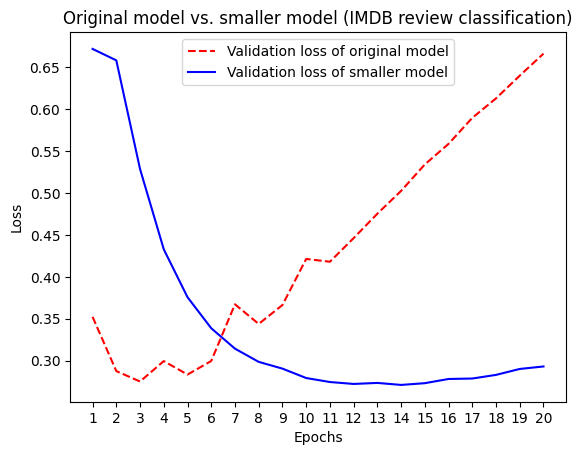

In [18]:
epochs = range(1, EPOCHS+1)
plt.plot(epochs, val_loss_original, "r--", label="Validation loss of original model")
plt.plot(epochs, val_loss_small, "b-", label="Validation loss of smaller model")
plt.title("Original model vs. smaller model (IMDB review classification)")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.xticks(epochs); plt.legend(); plt.show()

El modelo más pequeño (curva azul) obtiene una pérdida de validación menor que el original.

Esto indica que el modelo original sobreajusta: aprende demasiado bien los datos de entrenamiento y pierde capacidad de generalizar.

El modelo más pequeño, al tener menos parámetros, generaliza mejor y evita el sobreajuste.

## 7) Experimento 3: Modelo más grande (512-512)

Época 01/20 | train_loss=0.7979 | val_loss=0.4046 | val_acc=0.8307
Época 02/20 | train_loss=0.2397 | val_loss=0.2745 | val_acc=0.8869
Época 03/20 | train_loss=0.1401 | val_loss=0.3325 | val_acc=0.8687
Época 04/20 | train_loss=0.0684 | val_loss=0.3540 | val_acc=0.8866
Época 05/20 | train_loss=0.0283 | val_loss=0.4216 | val_acc=0.8850
Época 06/20 | train_loss=0.0116 | val_loss=0.4949 | val_acc=0.8817
Época 07/20 | train_loss=0.0041 | val_loss=0.5677 | val_acc=0.8814
Época 08/20 | train_loss=0.0013 | val_loss=0.6442 | val_acc=0.8816
Época 09/20 | train_loss=0.0005 | val_loss=0.7027 | val_acc=0.8798
Época 10/20 | train_loss=0.0003 | val_loss=0.7486 | val_acc=0.8792
Época 11/20 | train_loss=0.0001 | val_loss=0.7993 | val_acc=0.8782
Época 12/20 | train_loss=0.0001 | val_loss=0.8403 | val_acc=0.8788
Época 13/20 | train_loss=0.0001 | val_loss=0.8761 | val_acc=0.8788
Época 14/20 | train_loss=0.0000 | val_loss=0.9072 | val_acc=0.8789
Época 15/20 | train_loss=0.0000 | val_loss=0.9411 | val_acc=0.

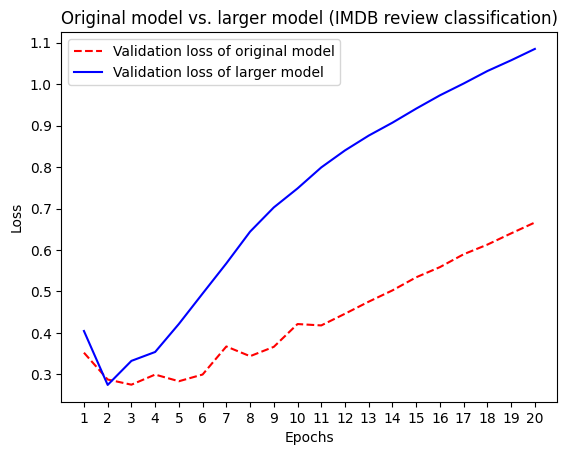

In [19]:
model_large = MLP(512, 512)
hist_large, model_large = train_one_model(model_large, train_loader, val_loader, epochs=EPOCHS, lr=1e-3)
val_loss_large = hist_large["val_loss"]

epochs = range(1, EPOCHS+1)
plt.plot(epochs, val_loss_original, "r--", label="Validation loss of original model")
plt.plot(epochs, val_loss_large, "b-", label="Validation loss of larger model")
plt.title("Original model vs. larger model (IMDB review classification)")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.xticks(epochs); plt.legend(); plt.show()

El modelo más grande (curva azul) tiene una pérdida de validación mucho mayor que el original.

Significa que este modelo sobreajusta aún más: memoriza los datos de entrenamiento, pero su rendimiento en validación empeora rápidamente.

En otras palabras, demasiada capacidad sin regularización conduce a overfitting severo.

## 8) Experimento 4: Regularización L2 (weight_decay)

Regularización L2: técnica que añade un término al costo penalizando pesos grandes → fuerza a la red a aprender parámetros más pequeños y distribuidos, evitando que se sobreajuste.

Época 01/20 | train_loss=0.5119 | val_loss=0.3629 | val_acc=0.8772
Época 02/20 | train_loss=0.3061 | val_loss=0.3187 | val_acc=0.8762
Época 03/20 | train_loss=0.2413 | val_loss=0.2866 | val_acc=0.8843
Época 04/20 | train_loss=0.2131 | val_loss=0.2981 | val_acc=0.8810
Época 05/20 | train_loss=0.1832 | val_loss=0.2827 | val_acc=0.8864
Época 06/20 | train_loss=0.1797 | val_loss=0.3134 | val_acc=0.8734
Época 07/20 | train_loss=0.1647 | val_loss=0.2882 | val_acc=0.8840
Época 08/20 | train_loss=0.1522 | val_loss=0.3132 | val_acc=0.8765
Época 09/20 | train_loss=0.1389 | val_loss=0.3184 | val_acc=0.8754
Época 10/20 | train_loss=0.1373 | val_loss=0.3401 | val_acc=0.8705
Época 11/20 | train_loss=0.1298 | val_loss=0.3318 | val_acc=0.8746
Época 12/20 | train_loss=0.1236 | val_loss=0.4984 | val_acc=0.8270
Época 13/20 | train_loss=0.1183 | val_loss=0.3204 | val_acc=0.8776
Época 14/20 | train_loss=0.1121 | val_loss=0.5284 | val_acc=0.8248
Época 15/20 | train_loss=0.1204 | val_loss=0.3343 | val_acc=0.

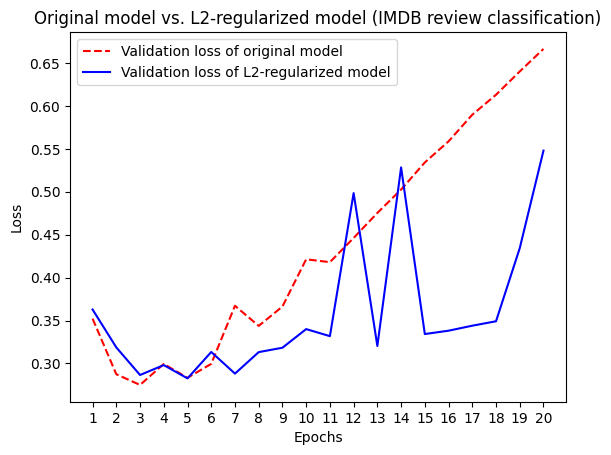

In [20]:
model_l2 = MLP(16, 16)
hist_l2, model_l2 = train_one_model(model_l2, train_loader, val_loader,
                                    epochs=EPOCHS, lr=1e-3, weight_decay=0.002)
val_loss_l2 = hist_l2["val_loss"]

epochs = range(1, EPOCHS+1)
plt.plot(epochs, val_loss_original, "r--", label="Validation loss of original model")
plt.plot(epochs, val_loss_l2, "b-", label="Validation loss of L2-regularized model")
plt.title("Original model vs. L2-regularized model (IMDB review classification)")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.xticks(epochs); plt.legend(); plt.show()

El modelo con L2 (curva azul) se mantiene con pérdida de validación más baja que el original (rojo), aunque con oscilaciones.

Esto muestra que L2 ayuda a limitar el sobreajuste, aunque introduce cierta inestabilidad durante el entrenamiento.

En general, logra mejor generalización que el modelo sin regularizar.

## 9) Experimento 5: Dropout (0.5)

Dropout: técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas en cada batch, evitando que la red dependa demasiado de ciertas conexiones.

Época 01/20 | train_loss=0.6043 | val_loss=0.4345 | val_acc=0.8651
Época 02/20 | train_loss=0.4188 | val_loss=0.3099 | val_acc=0.8861
Época 03/20 | train_loss=0.3220 | val_loss=0.2943 | val_acc=0.8812
Época 04/20 | train_loss=0.2729 | val_loss=0.2684 | val_acc=0.8907
Época 05/20 | train_loss=0.2355 | val_loss=0.2779 | val_acc=0.8884
Época 06/20 | train_loss=0.2044 | val_loss=0.2744 | val_acc=0.8913
Época 07/20 | train_loss=0.1800 | val_loss=0.2900 | val_acc=0.8874
Época 08/20 | train_loss=0.1612 | val_loss=0.3071 | val_acc=0.8864
Época 09/20 | train_loss=0.1449 | val_loss=0.3123 | val_acc=0.8888
Época 10/20 | train_loss=0.1261 | val_loss=0.3349 | val_acc=0.8873
Época 11/20 | train_loss=0.1159 | val_loss=0.3676 | val_acc=0.8874
Época 12/20 | train_loss=0.1006 | val_loss=0.3662 | val_acc=0.8875
Época 13/20 | train_loss=0.0907 | val_loss=0.4168 | val_acc=0.8871
Época 14/20 | train_loss=0.0777 | val_loss=0.4416 | val_acc=0.8866
Época 15/20 | train_loss=0.0714 | val_loss=0.4570 | val_acc=0.

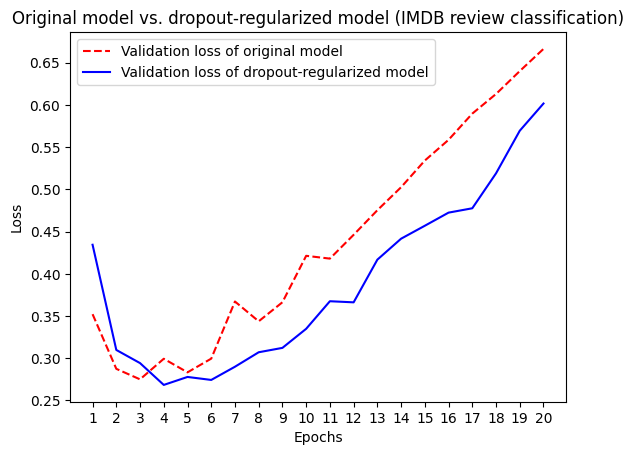

In [21]:
model_dropout = MLP(16, 16, p_dropout=0.5)
hist_dropout, model_dropout = train_one_model(model_dropout, train_loader, val_loader, epochs=EPOCHS, lr=1e-3)
val_loss_dropout = hist_dropout["val_loss"]

epochs = range(1, EPOCHS+1)
plt.plot(epochs, val_loss_original, "r--", label="Validation loss of original model")
plt.plot(epochs, val_loss_dropout, "b-", label="Validation loss of dropout-regularized model")
plt.title("Original model vs. dropout-regularized model (IMDB review classification)")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.xticks(epochs); plt.legend(); plt.show()

El modelo con dropout (curva azul) tiene menor pérdida de validación que el original.

Aunque la curva sube con las épocas, aún generaliza mejor que el modelo base.

Dropout reduce el sobreajuste al hacer la red más robusta y menos dependiente de combinaciones específicas de neurona

## Conclusiones Generales

- Los modelos con **demasiados parámetros** (modelo más grande) tienden a **sobreajustar** rápidamente, lo que se refleja en una pérdida de validación creciente y un mal desempeño al generalizar.

- Reducir la **capacidad del modelo** (modelo más pequeño) puede mejorar la **generalización**, ya que limita la complejidad y evita que el modelo memorice los datos de entrenamiento.

- Aplicar **regularización L2** ayuda a controlar el sobreajuste penalizando pesos grandes, lo que distribuye mejor la información aprendida y mejora la estabilidad del modelo.

- El uso de **Dropout** introduce ruido controlado durante el entrenamiento, obligando a la red a no depender de conexiones específicas. Esto también reduce el sobreajuste y favorece la robustez del modelo.

- En conjunto, se observa que la **clave para un buen desempeño** en validación no es tener el modelo más grande posible, sino **balancear la capacidad con técnicas de regularización** adecuadas.
